## **Scanpy Host-Microbiome data**

### **CHIP A04100E4**

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
random.seed(123)
np.random.seed(123)

import os
import sys
sys.path.insert(0, "/scratch_isilon/groups/singlecell/data/STEREOSEQ_RAW/Stereoseq_analysis/scripts/segmentation_based")

from custom_functions import spatialDensityFeaturePlot, spatialFeaturePlot, spatialClonePlot

In [2]:
%load_ext autoreload
%autoreload 2

### **Loading data**

In [3]:
hdata = sc.read_h5ad("/home/groups/singlecell/cfernandez/test_A04100E4_75binS.h5ad")
hdata

AnnData object with n_obs × n_vars = 11786 × 24332
    obs: 'orig.ident', 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'underTissue', 'keep'
    var: 'mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'binSize', 'bin_size', 'bin_type', 'description', 'key_record', 'merged', 'orig_var_names', 'resolution', 'sn', 'spatial'
    obsm: 'spatial'

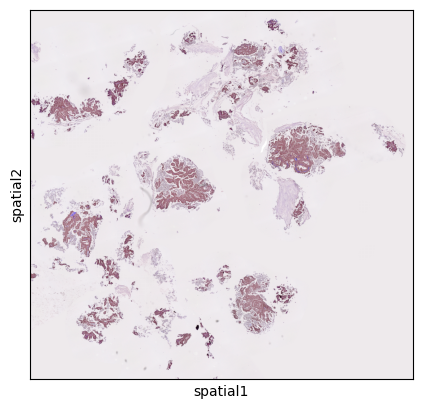

In [4]:
sc.pl.spatial(hdata, img_key='HeElowRes', spot_size=1, alpha=1)

In [5]:
print(f'Bin size 75 loaded. Format: {hdata.shape}')

# Make the list for the metrices
spots = []
genes = []
median_total_counts = []
median_n_genes_by_counts = []

# Number of spots and genes
spots.append(hdata.n_obs)
genes.append(hdata.n_vars)

# Medians
median_total_counts.append(hdata.obs['total_counts'].median())
median_n_genes_by_counts.append(hdata.obs['n_genes_by_counts'].median())

# DataFrame
summary_df = pd.DataFrame({
    'Bin size': ['75'],
    'Total spots': spots,
    'Total genes': genes,
    'Median counts': median_total_counts,
    'Median genes': median_n_genes_by_counts})

summary_df

Bin size 75 loaded. Format: (11786, 24332)


,Bin size,Total spots,Total genes,Median counts,Median genes
0,75,11786,24332,347.0,278.0


In [6]:
total_counts = hdata.obs['total_counts']

high_counts = total_counts[total_counts > 2000]
print(high_counts)

65068754544600    3878
Name: total_counts, dtype: uint64


### **Visualization**

<Axes: xlabel='n_genes_by_counts', ylabel='Count'>

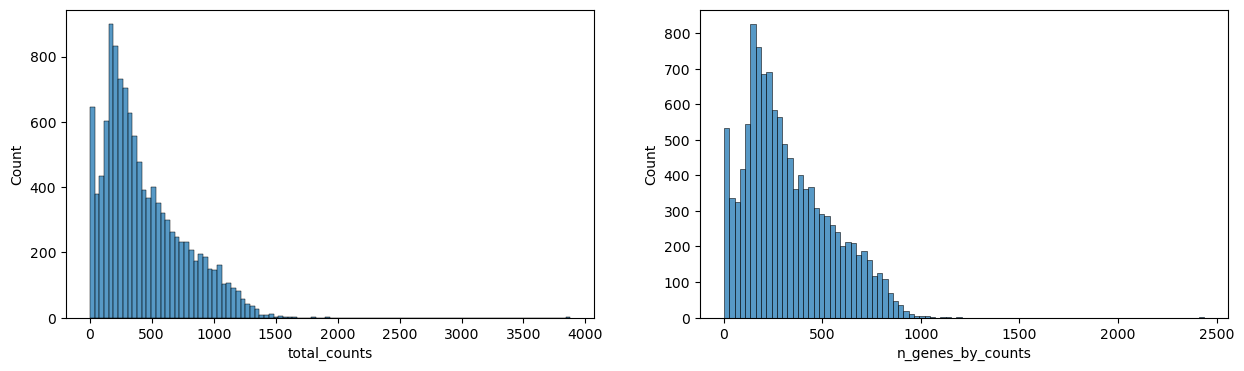

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.histplot(hdata.obs["total_counts"], kde=False, ax=axs[0])
sns.histplot(hdata.obs["n_genes_by_counts"], kde=False, ax=axs[1])

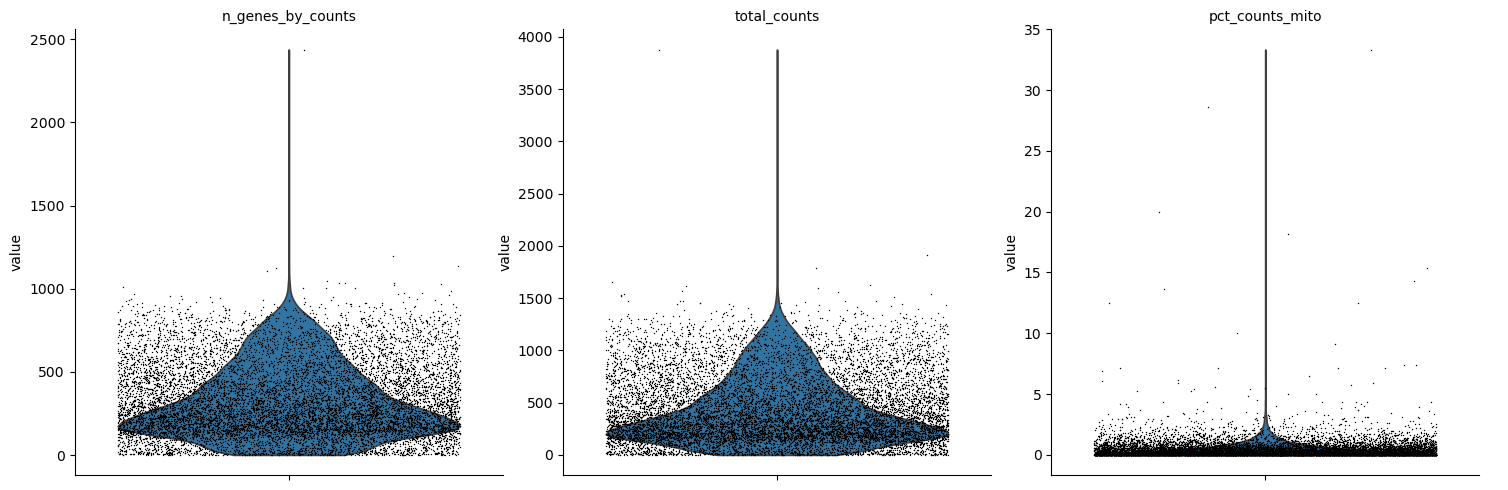

In [8]:
sc.pl.violin(
    hdata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mito"],
    jitter=0.4,
    multi_panel=True,)

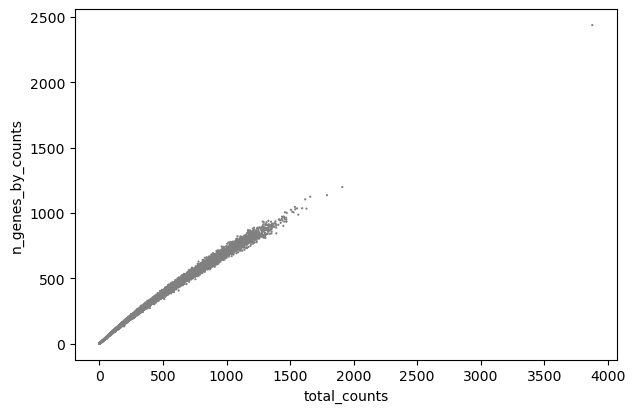

In [9]:
sc.pl.scatter(hdata, "total_counts", "n_genes_by_counts")

In [10]:
sc.pp.filter_cells(hdata, max_counts=2000) # Removing one really high spot

<Axes: xlabel='n_genes_by_counts', ylabel='Count'>

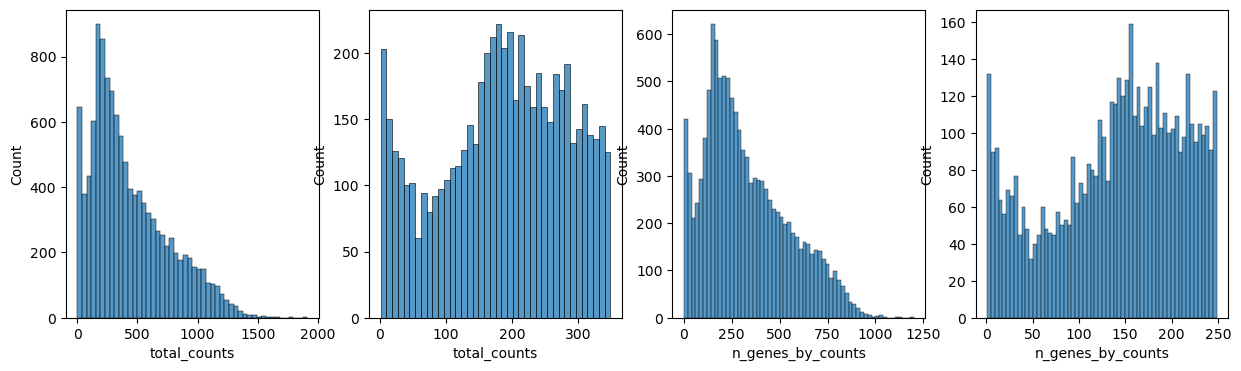

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.histplot(hdata.obs["total_counts"], kde=False, ax=axs[0])
sns.histplot(
    hdata.obs["total_counts"][hdata.obs["total_counts"] < 350],
    kde=False,
    bins=40,
    ax=axs[1],)

sns.histplot(hdata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.histplot(
    hdata.obs["n_genes_by_counts"][hdata.obs["n_genes_by_counts"] < 250],
    kde=False,
    bins=60,
    ax=axs[3],)

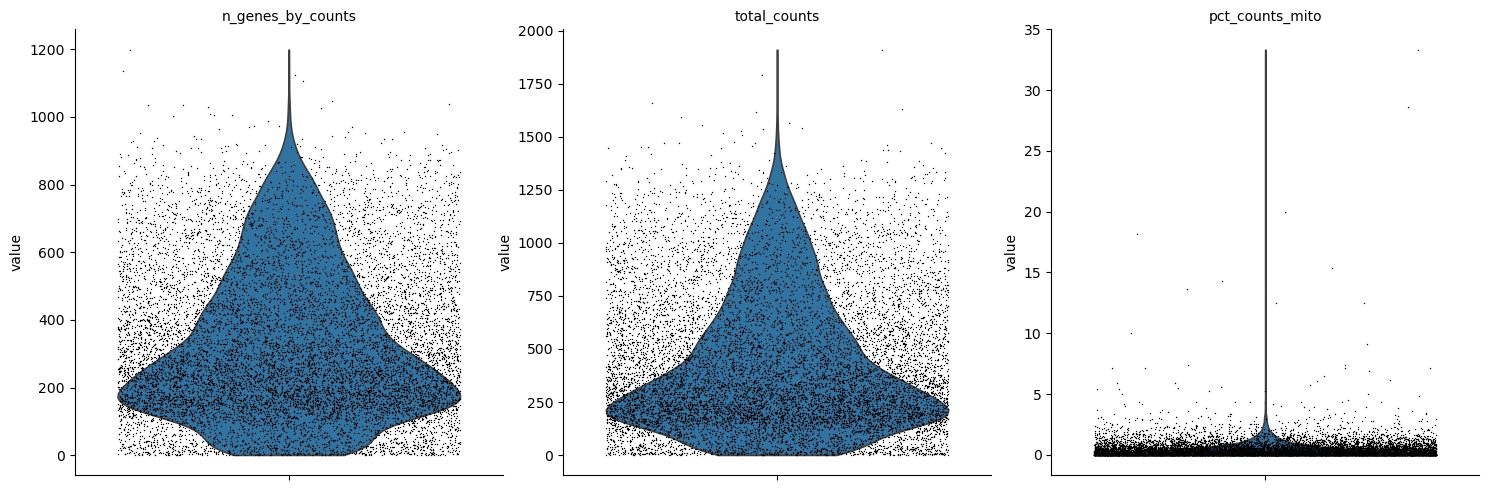

In [12]:
sc.pl.violin(
    hdata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mito"],
    jitter=0.4,
    multi_panel=True,)

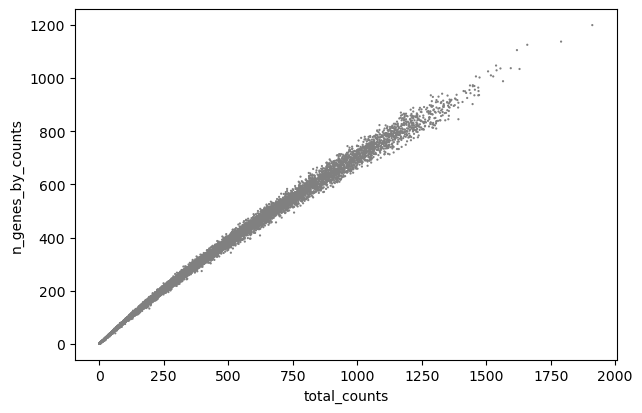

In [13]:
sc.pl.scatter(hdata, "total_counts", "n_genes_by_counts")

### **Filterings**

In [14]:
# Gene names to strings
gene_names = hdata.var_names.astype(str)

# Remove
has_dot = gene_names.str.contains(r'\.', regex=True)
is_NEAT1 = gene_names == 'NEAT1'
is_MALAT1 = gene_names == 'MALAT1'
is_mito = gene_names.str.startswith(('MT-', 'mt-'))
is_ribo = gene_names.str.startswith(('RPS', 'RPL'))

to_remove = has_dot | is_NEAT1 | is_MALAT1 | is_mito | is_ribo

# Invert
genes_to_keep = ~to_remove

# Apply filter
hdata = hdata[:, genes_to_keep].copy()


In [15]:
# Object with counts < 2000 and spots with minimum counts of 30, minimum 10 cells with a gene and <5% mitocondrial
sc.pp.filter_cells(hdata, min_counts=200)
sc.pp.filter_genes(hdata, min_cells=5)
#hdata = hdata[hdata.obs["pct_counts_mito"] < 5].copy()
print(f"cells after filters: {hdata.n_obs}")

cells after filters: 8243


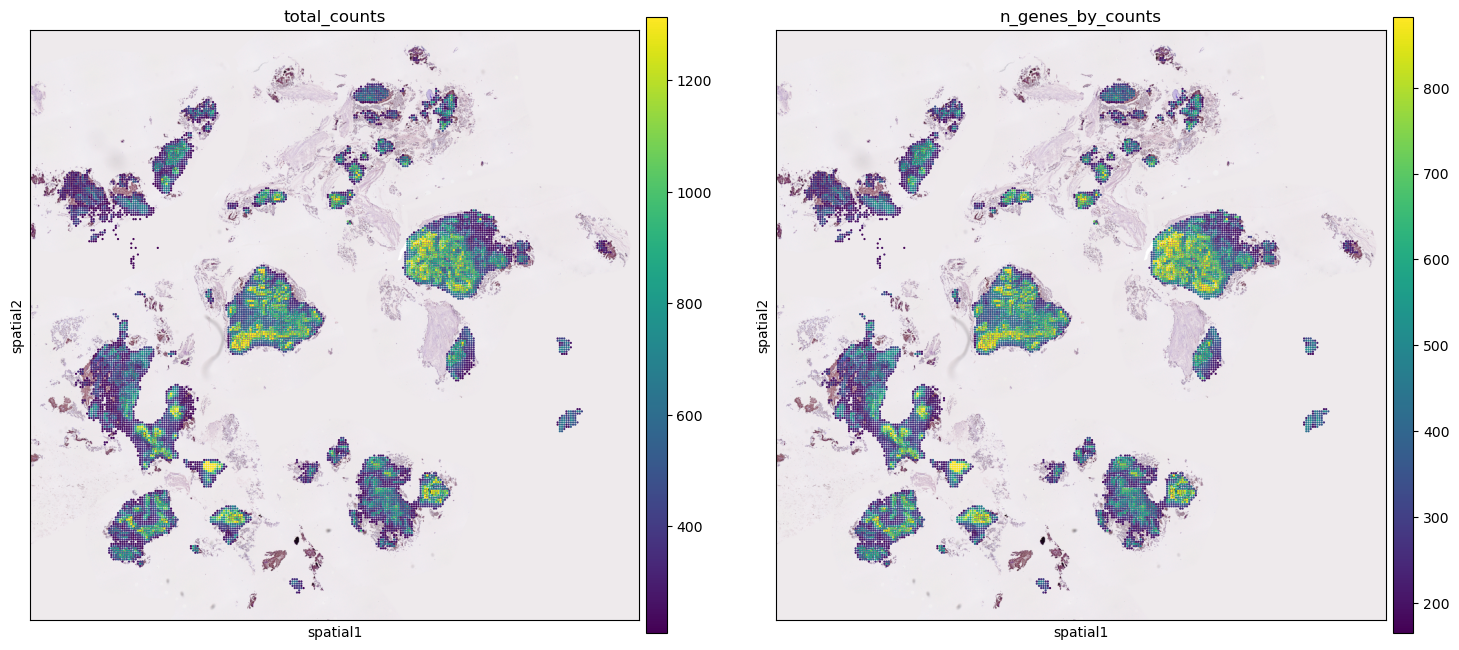

In [16]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(hdata,
              img_key="HeElowRes",
              color=["total_counts", "n_genes_by_counts"],
              vmax='p99',
              #save= "_spatial_A04100E4.png")

### **Normalization**

In [17]:
# Save raw data
adata = hdata.copy()

# Normalizing to median total counts
sc.pp.normalize_total(hdata, target_sum=1e4)
# Logarithmize the data
sc.pp.log1p(hdata)

hdata.raw = hdata

### **Feature Selection**

2044


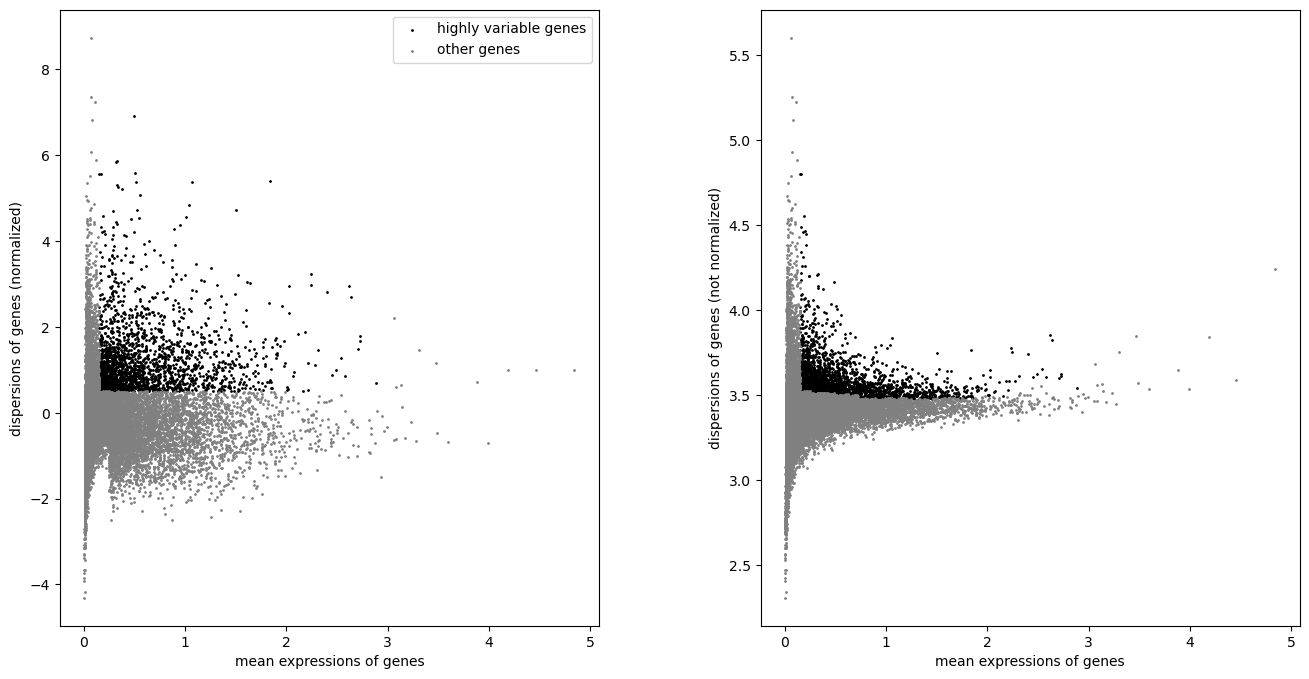

In [18]:
# Select highly variable genes
sc.pp.highly_variable_genes(
    hdata,
    min_mean=0.15,
    max_mean=3,
    min_disp=0.5,
    flavor = 'seurat',
    subset=False)

print(hdata.var['highly_variable'].sum())

# Visualization
sc.pl.highly_variable_genes(hdata, #save= "_hvg_A04100E4.png")

In [19]:
hdata

AnnData object with n_obs × n_vars = 8243 × 14929
    obs: 'orig.ident', 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'underTissue', 'keep', 'n_counts'
    var: 'mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'binSize', 'bin_size', 'bin_type', 'description', 'key_record', 'merged', 'orig_var_names', 'resolution', 'sn', 'spatial', 'log1p', 'hvg'
    obsm: 'spatial'

### **Embedding**

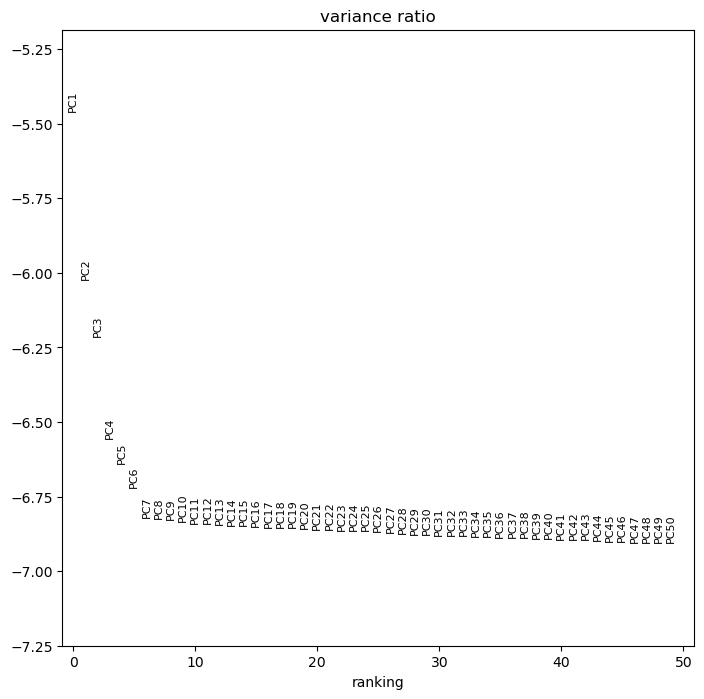

In [19]:
# PCA
sc.pp.scale(hdata)
sc.tl.pca(hdata, n_comps=50)
sc.pl.pca_variance_ratio(hdata, n_pcs=50, log=True, #save= "_A04100E4.png")

### **Nearest neighbor graph constuction and visualization**

In [20]:
# Neighbors and UMAP
sc.pp.neighbors(hdata, n_pcs=25)
sc.tl.umap(hdata)

### **Clustering**

In [21]:
# Clustering Leiden 
sc.tl.leiden(hdata, resolution=0.7, key_added='leiden_0.7', random_state=123)

/home/groups/singlecell/cfernandez/miniconda3/envs/stereopy_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


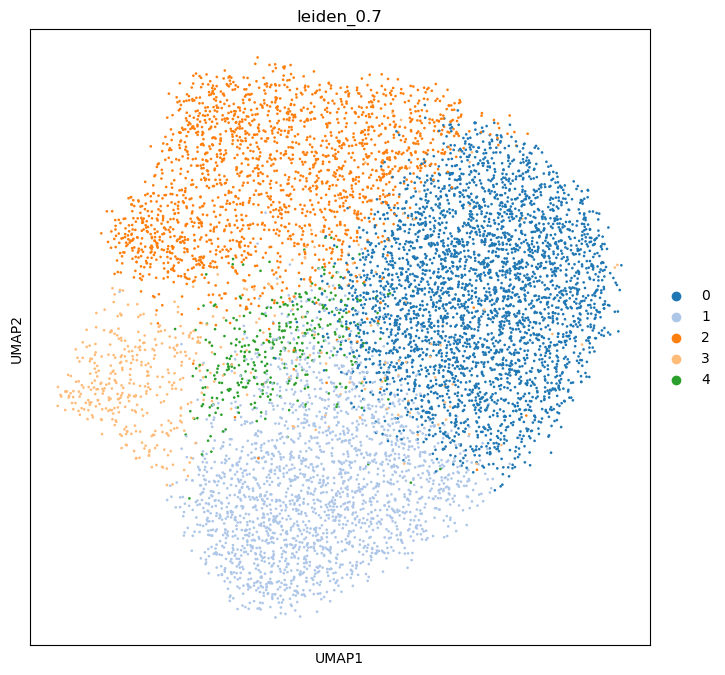

In [22]:
# UMAP plot (for resolution 0.7)
palette = sns.color_palette("tab20", n_colors=20)
sc.pl.umap(hdata, color='leiden_0.7', palette=palette, #save= "_A04100E4.png")

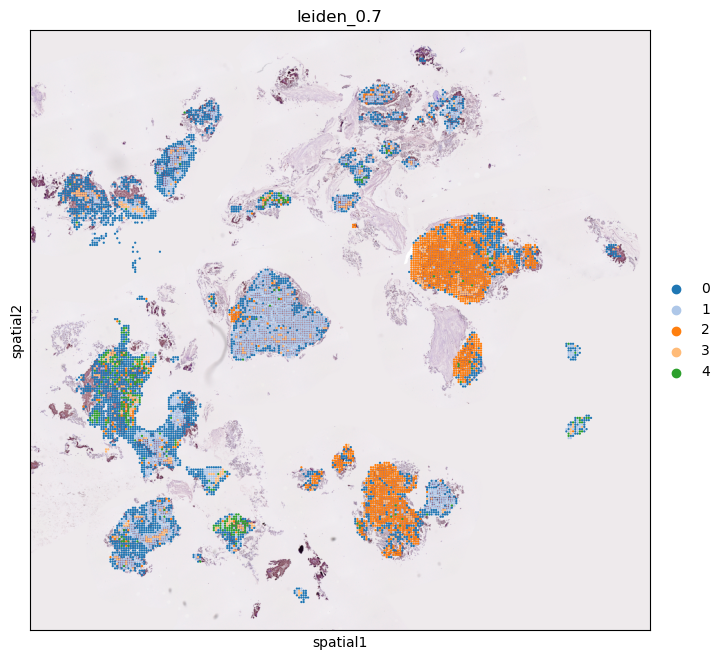

[<Axes: title={'center': 'leiden_0.7'}, xlabel='spatial1', ylabel='spatial2'>]

In [23]:
# Spatial scatter
sc.pl.spatial(
        hdata,
        color='leiden_0.7',
        img_key= 'HeElowRes',
        alpha=1.0,             
        palette=palette,
        return_fig=True,
        #save= "_clusters_A04100E4.png")

/home/groups/singlecell/cfernandez/miniconda3/envs/stereopy_env/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/groups/singlecell/cfernandez/miniconda3/envs/stereopy_env/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:839: UserWarning: The palette list has more values (20) than needed (5), which may not be intended.
  ax = sns.violinplot(
/home/groups/singlecell/cfernandez/miniconda3/envs/stereopy_env/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


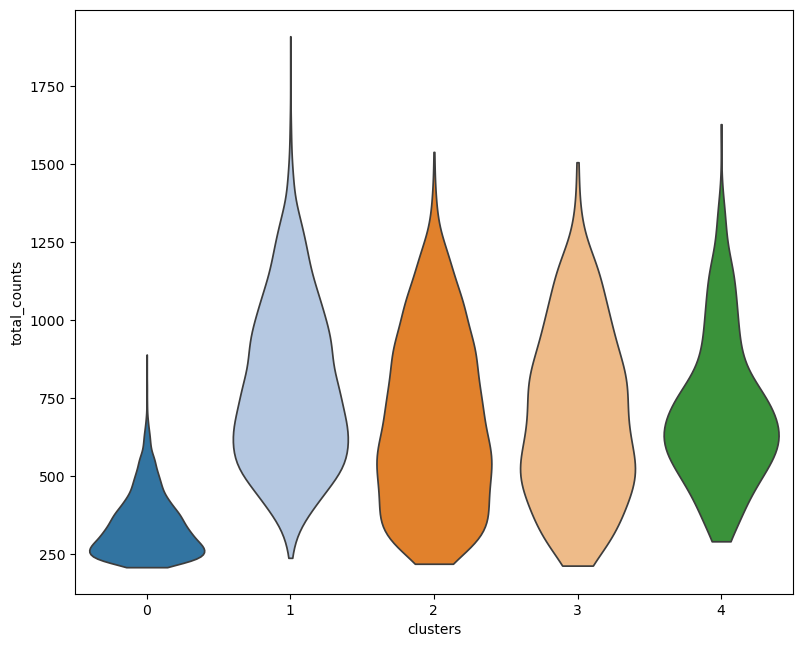

In [24]:
# Violin plot 
sc.pl.violin(
        hdata,
        keys=['total_counts'],  
        groupby='leiden_0.7',
        jitter=0.4,
        stripplot=False,
        palette= palette,
        xlabel= 'clusters',
        #save= "_clusters_A04100E4.png")

### **Marker Genes**

In [25]:
hdata

AnnData object with n_obs × n_vars = 8243 × 14929
    obs: 'orig.ident', 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'underTissue', 'keep', 'n_counts', 'leiden_0.7'
    var: 'mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'binSize', 'bin_size', 'bin_type', 'description', 'key_record', 'merged', 'orig_var_names', 'resolution', 'sn', 'spatial', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_0.7_colors'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connecti

In [26]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(hdata, 
                            groupby='leiden_0.7', 
                            use_raw=True, 
                            layer=None, 
                            method='wilcoxon', 
                            key_added='rank_genes_leiden_0.7')

/home/groups/singlecell/cfernandez/miniconda3/envs/stereopy_env/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


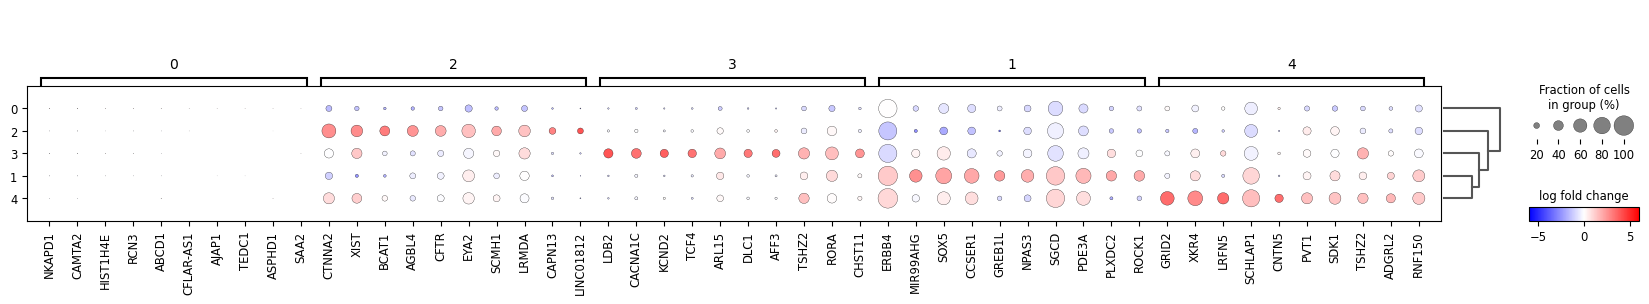

In [27]:
# Dotplot
sc.pl.rank_genes_groups_dotplot(
        hdata,
        key='rank_genes_leiden_0.7',  
        values_to_plot="logfoldchanges",
        groupby='leiden_0.7',
        n_genes=10,
        vmax = 6,
        vmin=-6,
        min_logfoldchange = 1,
        cmap='bwr',
        colorbar_title='log fold change')

/home/groups/singlecell/cfernandez/miniconda3/envs/stereopy_env/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


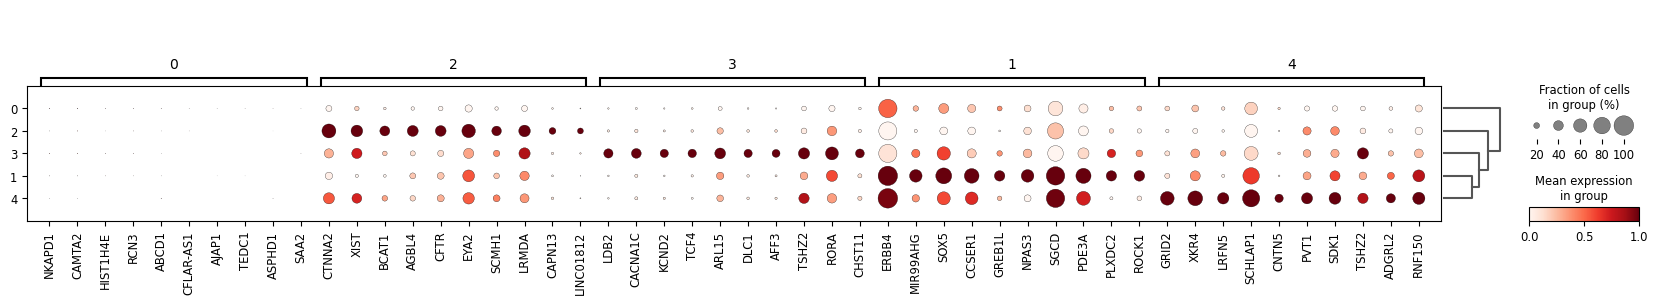

In [28]:
# Dotplot
sc.pl.rank_genes_groups_dotplot(
        hdata,
        key='rank_genes_leiden_0.7',  
        groupby='leiden_0.7',
        n_genes=10,
        min_logfoldchange = 1,
        standard_scale='var',
        #save= "_A04100E4.png")

### **Annotations Spatial Scatter**

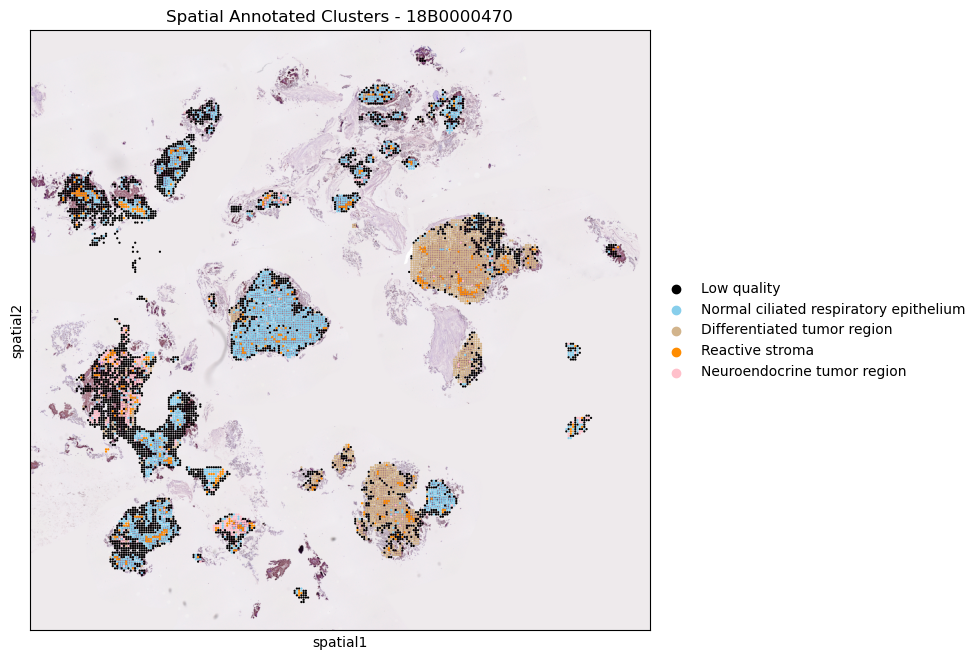

[<Axes: title={'center': 'Spatial Annotated Clusters - 18B0000470'}, xlabel='spatial1', ylabel='spatial2'>]

In [35]:
# Annotations per cluster
cluster_annotations = {
    '0': 'Low quality',
    '1': 'Normal ciliated respiratory epithelium',
    '2': 'Differentiated tumor region',
    '3': 'Reactive stroma',
    '4': 'Neuroendocrine tumor region'}

# Custom color palette
annotation_palette = {
    'Low quality': 'black',
    'Neuroendocrine tumor region': 'pink',
    'Reactive stroma': 'darkorange',
    'Normal ciliated respiratory epithelium': 'skyblue',
    'Differentiated secretory tumor region': 'green',
    'Differentiated tumor region': 'tan',
    'Invasive front': 'yellow'}

# New column with annotations
hdata.obs['cluster_annot'] = hdata.obs['leiden_0.7'].map(cluster_annotations)

# Plot annotated clustering 
sc.pl.spatial(
    hdata,
    color='cluster_annot',
    img_key='HeElowRes',
    alpha=1.0,
    title='Spatial Annotated Clusters - 18B0000470',
    palette=annotation_palette,  
    return_fig=True,
    #save= "_annotated_A04100E4.png")

In [36]:
hdata

AnnData object with n_obs × n_vars = 8243 × 14929
    obs: 'orig.ident', 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'underTissue', 'keep', 'n_counts', 'leiden_0.7', 'cluster_annot'
    var: 'mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'binSize', 'bin_size', 'bin_type', 'description', 'key_record', 'merged', 'orig_var_names', 'resolution', 'sn', 'spatial', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_0.7_colors', 'rank_genes_leiden_0.7', 'dendrogram_leiden_0.7', 'cluster_annot_colo

In [ ]:
#hdata.write("final_A04100E4_host.h5ad")